# Importanto bibliotecas

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [74]:
import json

# Carrega o JSON em formato aninhado
with open("TelecomX_Data.json", "r") as f:
    raw_data = json.load(f)

# Transforma o JSON em DataFrame (pode exigir normalização)
df = pd.json_normalize(raw_data)

In [75]:
# Verifica valores únicos da coluna 'Churn' antes da limpeza
churn_before = df['Churn'].value_counts(dropna=False)

# Remove registros onde 'Churn' está vazio ou nulo
df_cleaned = df[df['Churn'].isin(['Yes', 'No'])].copy()

# Verifica valores únicos da coluna 'Churn' após a limpeza
churn_after = df_cleaned['Churn'].value_counts(dropna=False)

# Verifica se há outros valores ausentes no DataFrame limpo
missing_values = df_cleaned.isnull().sum()

# Exibe os resultados
churn_before, churn_after, missing_values[missing_values > 0]
# Verifica se há outros campos nulos

(Churn
 No     5174
 Yes    1869
         224
 Name: count, dtype: int64,
 Churn
 No     5174
 Yes    1869
 Name: count, dtype: int64,
 Series([], dtype: int64))

In [76]:
print(df.isnull().sum())

customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
account.Charges.Total        0
dtype: int64


In [77]:
# Separando variáveis explicativas (X) e alvo (y)
x = df.drop('Churn', axis =1)
y = df ['Churn']

print(f'x: {x.shape}, y: {y.shape}')

print("Antes da Divisão:", x.shape, y.shape)
assert len(x) == len(y), "Erro: x e y devem ter o mesmo número de linhas!"
df_info = df.info()
df_head = df.head()
df_describe = df.describe(include='all')

print(df_head, df_info, df_describe)

x: (7267, 20), y: (7267,)
Antes da Divisão: (7267, 20) (7267,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null 

In [78]:
# Copiando o DataFrame limpo
df_model = df_cleaned.copy()

# Verifica colunas categóricas (tipo 'object')
categorical_columns = df_model.select_dtypes(include='object').columns.tolist()

# Mostra as colunas categóricas para inspeção
categorical_columns

['customerID',
 'Churn',
 'customer.gender',
 'customer.Partner',
 'customer.Dependents',
 'phone.PhoneService',
 'phone.MultipleLines',
 'internet.InternetService',
 'internet.OnlineSecurity',
 'internet.OnlineBackup',
 'internet.DeviceProtection',
 'internet.TechSupport',
 'internet.StreamingTV',
 'internet.StreamingMovies',
 'account.Contract',
 'account.PaperlessBilling',
 'account.PaymentMethod',
 'account.Charges.Total']

In [79]:
# Remove a coluna de ID
df_model.drop(columns=['customerID'], inplace=True)

# Converte a variável alvo 'Churn' para 0 (No) e 1 (Yes)
df_model['Churn'] = df_model['Churn'].map({'No': 0, 'Yes': 1})

# Converte a coluna 'account.Charges.Total' de string para float
df_model['account.Charges.Total'] = pd.to_numeric(df_model['account.Charges.Total'], errors='coerce')

# Aplica One-Hot Encoding nas demais colunas categóricas (ignora 'Churn' que já está binário)
df_encoded = pd.get_dummies(df_model, drop_first=True)

# Verifica as primeiras colunas e o shape final
df_encoded.head(), df_encoded.shape

(   Churn  customer.SeniorCitizen  customer.tenure  account.Charges.Monthly  \
 0      0                       0                9                     65.6   
 1      0                       0                9                     59.9   
 2      1                       0                4                     73.9   
 3      1                       1               13                     98.0   
 4      1                       1                3                     83.9   
 
    account.Charges.Total  customer.gender_Male  customer.Partner_Yes  \
 0                 593.30                 False                  True   
 1                 542.40                  True                 False   
 2                 280.85                  True                 False   
 3                1237.85                  True                  True   
 4                 267.40                 False                  True   
 
    customer.Dependents_Yes  phone.PhoneService_Yes  \
 0                     True  

In [80]:
df


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,No,Female,0,No,No,13,Yes,No,DSL,...,No,No,Yes,No,No,One year,No,Mailed check,55.15,742.9
7263,9992-RRAMN,Yes,Male,0,Yes,No,22,Yes,Yes,Fiber optic,...,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.10,1873.7
7264,9992-UJOEL,No,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,50.30,92.75
7265,9993-LHIEB,No,Male,0,Yes,Yes,67,Yes,No,DSL,...,No,Yes,Yes,No,Yes,Two year,No,Mailed check,67.85,4627.65


In [81]:
# Estatísticas descritivas básicas para todas as colunas numéricas
desc_stats = df_encoded.describe().T  # Transposta para melhor leitura

# Adiciona a mediana separadamente
desc_stats["median"] = df_encoded.median()

desc_stats[['mean', 'median', 'std', 'min', 'max']]  # Mostra apenas as colunas mais relevantes

,mean,median,std,min,max
Churn,0.265370,0.000,0.441561,0.00,1.00
customer.SeniorCitizen,0.162147,0.000,0.368612,0.00,1.00
customer.tenure,32.371149,29.000,24.559481,0.00,72.00
account.Charges.Monthly,64.761692,70.350,30.090047,18.25,118.75
account.Charges.Total,2283.300441,1397.475,2266.771362,18.80,8684.80


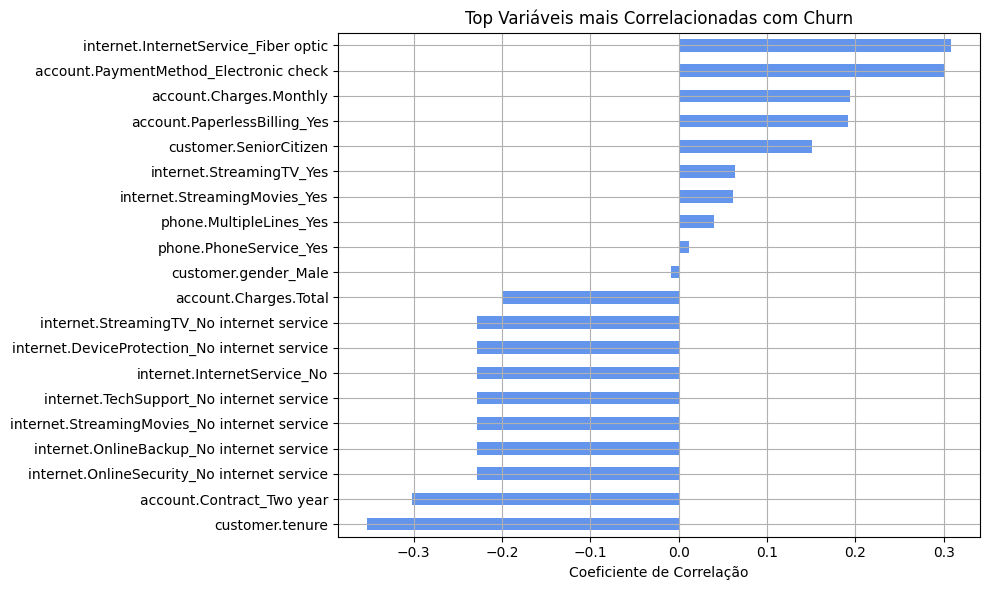


Matriz de Confusão:
[[921 114]
 [198 176]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



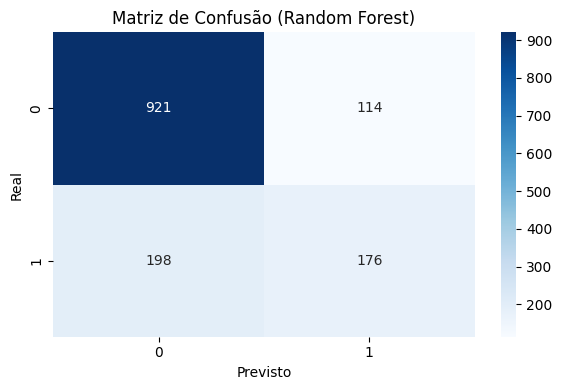

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Seleciona as variáveis mais correlacionadas
top_features = selecionar_variaveis_mais_correlacionadas(df_encoded, n_top=10)

# 2. Treina o modelo e obtém dados de teste
modelo_final, X_test, y_test = treinar_modelo_com_variaveis(df_encoded, top_features)


def treinar_modelo_com_variaveis(df_encoded, top_features, target_col='Churn'):
    """
    Treina e avalia um modelo RandomForest usando apenas as variáveis mais relevantes.
    Retorna o modelo treinado e os dados de teste.
    """
    X = df_encoded[top_features]
    y = df_encoded[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    modelo = RandomForestClassifier(random_state=42)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))

    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    return modelo, X_test, y_test



Matriz de Confusão:
[[921 114]
 [198 176]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



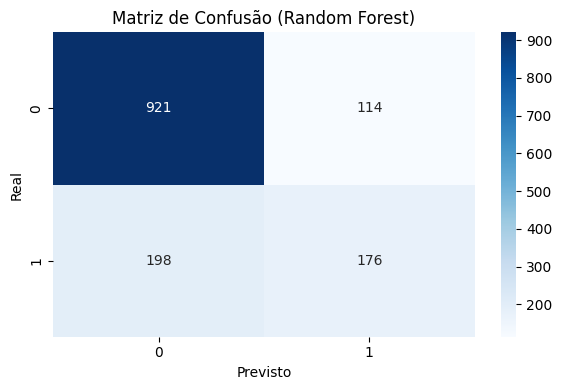

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Defina a função (com prints)
def treinar_modelo_com_variaveis(df_encoded, top_features, target_col='Churn'):
    X = df_encoded[top_features]
    y = df_encoded[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    modelo = RandomForestClassifier(random_state=42)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))

    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    # Gráfico da matriz de confusão
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusão (Random Forest)")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()
    return modelo, X_test, y_test

# 2. Depois chame a função
modelo_final, X_test, y_test = treinar_modelo_com_variaveis(df_encoded, top_features)


In [84]:
def verificar_balanceamento_target(y, nome_variavel='Churn'):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Se y for uma Series, criamos um DataFrame temporário para plotar
    if isinstance(y, pd.Series):
        df_temp = pd.DataFrame({nome_variavel: y})
    else:
        df_temp = y  # já é um DataFrame

    # Plot da distribuição
    sns.countplot(x=nome_variavel, data=df_temp)
    plt.title(f'Distribuição da Variável Alvo ({nome_variavel})')
    plt.xlabel(f'{nome_variavel} (0 = Não, 1 = Sim)')
    plt.ylabel('Contagem')
    plt.show()

    # Porcentagem de cada classe
    classe_counts = df_temp[nome_variavel].value_counts(normalize=True) * 100
    print(f"\nDistribuição percentual da variável alvo ({nome_variavel}):")
    print(classe_counts)

    # Verificação simples
    if classe_counts.min() < 30:
        print("\nA base está DESBALANCEADA.")
    else:
        print("\nA base está BALANCEADA.")


Antes do SMOTE:


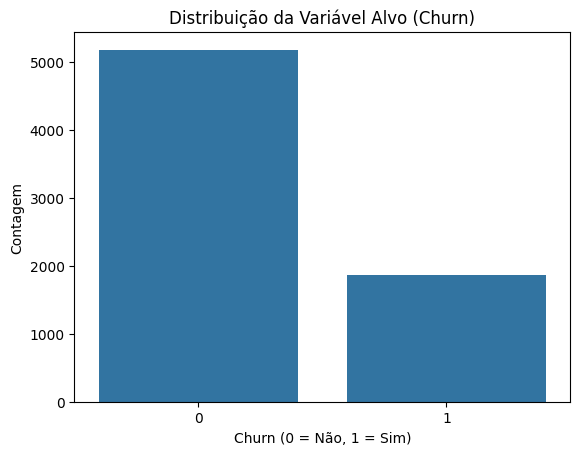


Distribuição percentual da variável alvo (Churn):
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64

A base está DESBALANCEADA.


In [85]:
print("Antes do SMOTE:")
verificar_balanceamento_target(df_encoded['Churn'])

Antes do SMOTE:
Distribuição das classes:
 - Classe 0: 5174 (73.46%)
 - Classe 1: 1869 (26.54%)
>>> Base desbalanceada.

Após aplicação do SMOTE (apenas no treino):
Distribuição das classes:
 - Classe 0: 4139 (50.00%)
 - Classe 1: 4139 (50.00%)
>>> Base balanceada.

Matriz de Confusão:
[[904 131]
 [184 190]]


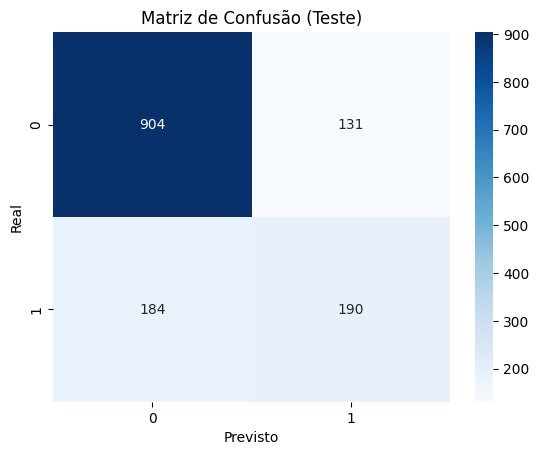


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.51      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

Acurácia: 0.7764371894960965
Precisão: 0.5919003115264797
Recall: 0.5080213903743316
F1-score: 0.5467625899280576

Após SMOTE (somente conjunto de treino):


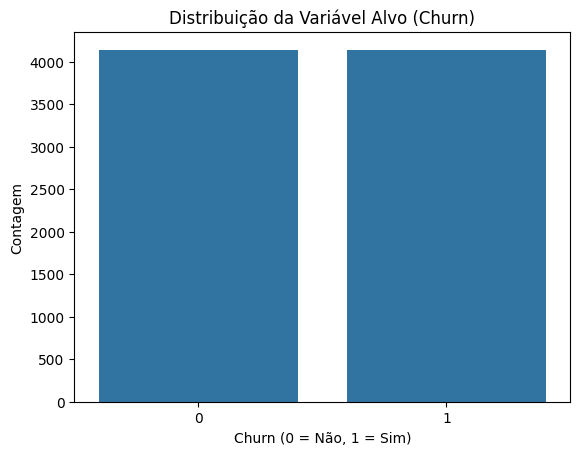


Distribuição percentual da variável alvo (Churn):
Churn
0    50.0
1    50.0
Name: proportion, dtype: float64

A base está BALANCEADA.


In [86]:
from sklearn.impute import SimpleImputer

def treinar_com_smote(df_encoded, top_features, target_col='Churn'):
    X = df_encoded[top_features]
    y = df_encoded[target_col]

    print("Antes do SMOTE:")
    avaliar_balanceamento(y)

    # Divide em treino e teste (antes de aplicar SMOTE para evitar vazamento)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Imputar valores faltantes no conjunto de treino
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Aplica SMOTE apenas no conjunto de treino imputado
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

    print("\nApós aplicação do SMOTE (apenas no treino):")
    avaliar_balanceamento(y_train_smote)

    # Treina o modelo RandomForest
    modelo = RandomForestClassifier(random_state=42)
    modelo.fit(X_train_smote, y_train_smote)

    # Prediz no conjunto de teste imputado
    y_pred = modelo.predict(X_test_imputed)

    # Avaliação do modelo
    print("\nMatriz de Confusão:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão (Teste)')
    plt.show()

    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    print("Acurácia:", accuracy_score(y_test, y_pred))
    print("Precisão:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))

    print("\nApós SMOTE (somente conjunto de treino):")
    verificar_balanceamento_target(pd.Series(y_train_smote, name='Churn'))

    return modelo, X_test_imputed, y_test, y_pred

# Usando as top_features já definidas anteriormente:
modelo_smote, X_test_smote, y_test_smote, y_pred_smote = treinar_com_smote(df_encoded, top_features)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


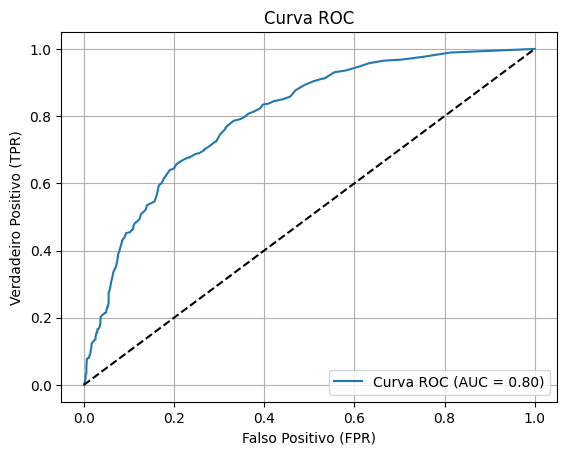


AUC: 0.7994


In [88]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilidades para classe positiva
y_prob = modelo_smote.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # linha de referência
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"\nAUC: {auc:.4f}")



📌 Importância das Variáveis no Modelo:
                                         Variável  Importância
19                          account.Charges.Total     0.195853
10                                customer.tenure     0.160649
2                         account.Charges.Monthly     0.140888
1          account.PaymentMethod_Electronic check     0.125225
11                      account.Contract_Two year     0.063258
0            internet.InternetService_Fiber optic     0.058895
3                    account.PaperlessBilling_Yes     0.056016
9                            customer.gender_Male     0.037651
4                          customer.SeniorCitizen     0.032258
7                         phone.MultipleLines_Yes     0.026824
6                    internet.StreamingMovies_Yes     0.023688
5                        internet.StreamingTV_Yes     0.022628
13      internet.OnlineBackup_No internet service     0.010042
16  internet.DeviceProtection_No internet service     0.009098
8              

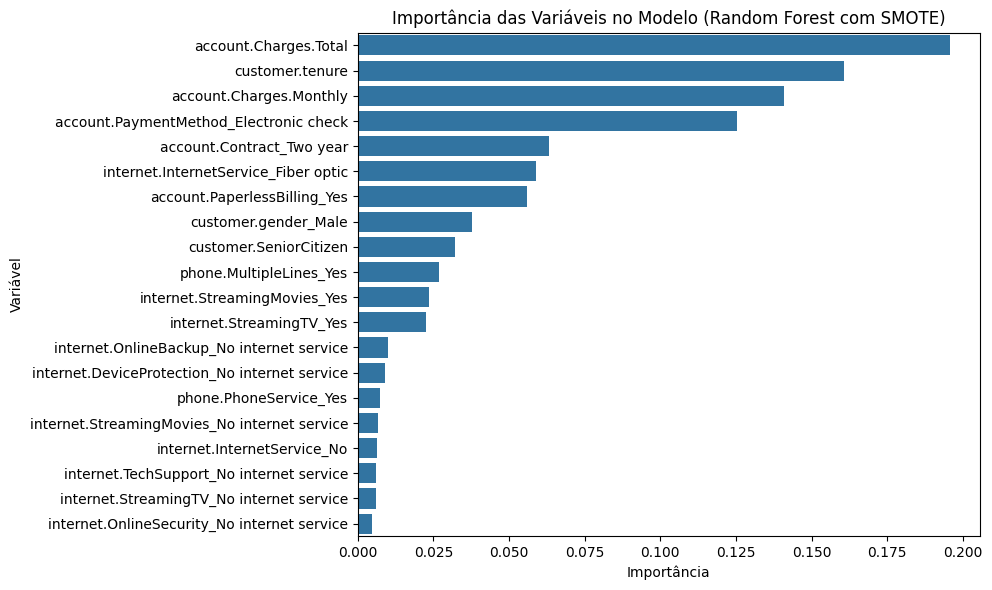

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtém as importâncias das features
importancias = modelo_smote.feature_importances_

# Cria um DataFrame com os nomes das variáveis e suas importâncias
importancia_df = pd.DataFrame({
    'Variável': X_test.columns,
    'Importância': importancias
}).sort_values(by='Importância', ascending=False)

# Exibe o DataFrame
print("\n📌 Importância das Variáveis no Modelo:")
print(importancia_df)

# Plot das importâncias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Variável', data=importancia_df)
plt.title('Importância das Variáveis no Modelo (Random Forest com SMOTE)')
plt.tight_layout()
plt.show()


In [91]:
import joblib

# Caminho e nome do arquivo para salvar
nome_arquivo_modelo = 'modelo_churn_rf_smote.pkl'

# Salvando o modelo treinado
joblib.dump(modelo_smote, nome_arquivo_modelo)

print(f"Modelo salvo com sucesso como '{nome_arquivo_modelo}'!")


Modelo salvo com sucesso como 'modelo_churn_rf_smote.pkl'!


In [103]:
X.loc[:, 'account.Charges.Total'] = X['account.Charges.Total'].fillna(X['account.Charges.Total'].mean())

In [104]:
X = X.fillna(X.mean())  # Exemplo simples de imputação pela média (só para variáveis numéricas)

In [107]:
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # trata NaNs
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

X = df_encoded[top_features]
y = df_encoded['Churn']

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Validação Cruzada (5-fold):")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring=metric)
    print(f"{metric.capitalize():<10}: Média = {scores.mean():.4f} | Desvio Padrão = {scores.std():.4f}")


Validação Cruzada (5-fold):
Accuracy  : Média = 0.7811 | Desvio Padrão = 0.0091
Precision : Média = 0.5986 | Desvio Padrão = 0.0179
Recall    : Média = 0.5313 | Desvio Padrão = 0.0300
F1        : Média = 0.5626 | Desvio Padrão = 0.0224


In [108]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Definir pipeline com imputação, SMOTE e RandomForest
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Espaço de busca para hiperparâmetros do RandomForest
param_dist = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,               # número de combinações testadas
    scoring='f1',            # métrica para otimização (pode mudar)
    cv=kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Rodar busca
random_search.fit(X, y)

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)

print(f"Melhor F1-score na validação cruzada: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, *

Melhores parâmetros encontrados:
{'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 10}
Melhor F1-score na validação cruzada: 0.6190


In [109]:
# Atualiza o pipeline com os melhores parâmetros encontrados
best_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='log2',
        random_state=42
    ))
])

# Avaliação com k-fold usando as métricas
print("Avaliação do modelo otimizado (5-fold):")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(best_pipeline, X, y, cv=kfold, scoring=metric)
    print(f"{metric.capitalize():<10}: Média = {scores.mean():.4f} | Desvio Padrão = {scores.std():.4f}")

Avaliação do modelo otimizado (5-fold):
Accuracy  : Média = 0.7906 | Desvio Padrão = 0.0081
Precision : Média = 0.5981 | Desvio Padrão = 0.0124
Recall    : Média = 0.6421 | Desvio Padrão = 0.0347
F1        : Média = 0.6190 | Desvio Padrão = 0.0201


In [111]:
import joblib

# Salva o pipeline completo com o nome desejado
joblib.dump(best_pipeline, 'modelo_churn_rf_pipeline.joblib')

['modelo_churn_rf_pipeline.joblib']

In [ ]:
# Carrega o pipeline treinado
modelo_carregado = joblib.load('modelo_churn_rf_pipeline.joblib')

# Fazer previsões
y_pred = modelo_carregado.predict(novos_dados)


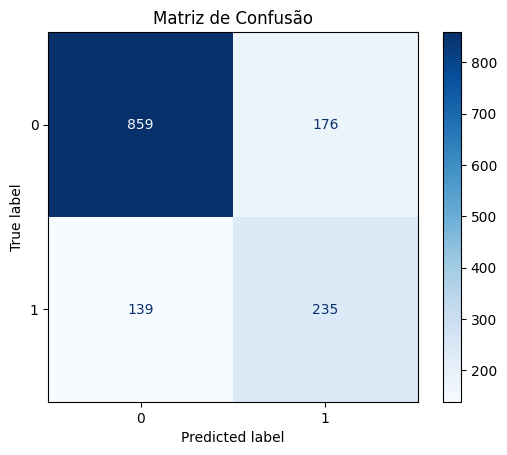

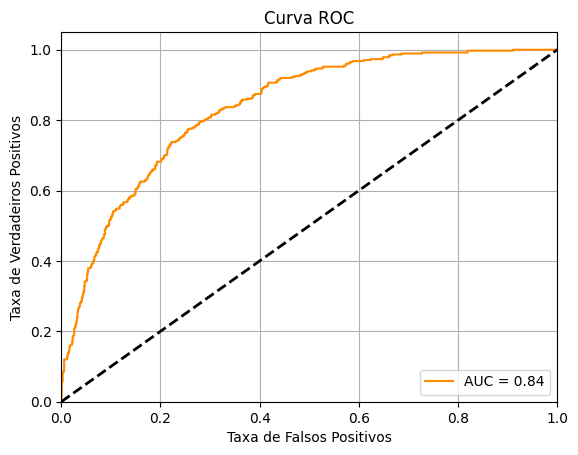

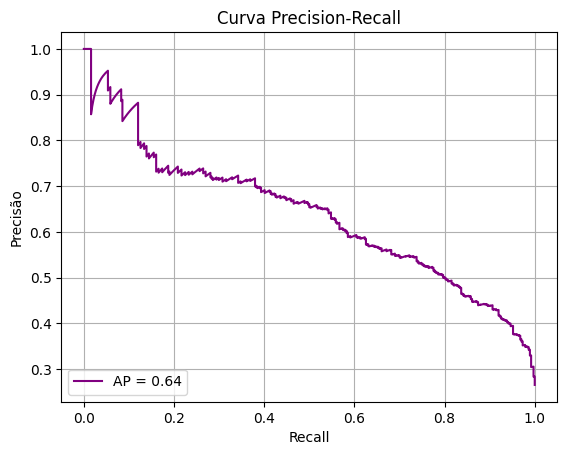

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Divide dados em treino/teste (só para gerar gráficos — não para validação cruzada)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Treina o pipeline otimizado no conjunto de treino
best_pipeline.fit(X_train, y_train)

# Previsões e probabilidades
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva

# === 1. MATRIZ DE CONFUSÃO ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

# === 2. CURVA ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# === 3. CURVA PRECISÃO-RECALL (PR Curve) ===
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, label=f'AP = {ap:.2f}', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [114]:
X = df_encoded[top_features]

/tmp/ipython-input-115-2721763803.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


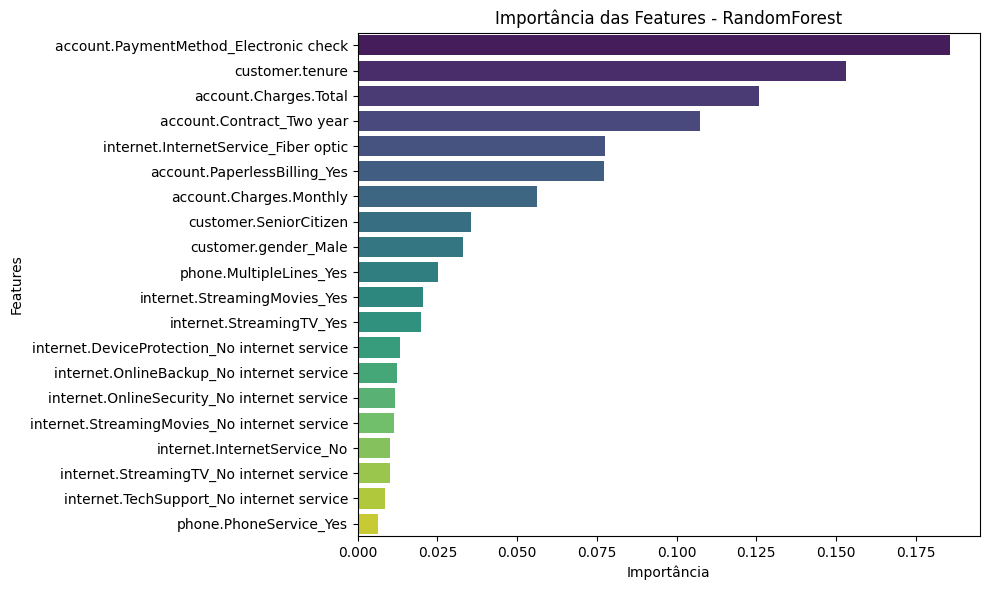

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extrai o modelo RandomForest do pipeline treinado
rf_model = best_pipeline.named_steps['rf']

# Usa os nomes das colunas de entrada (X)
feature_names = X.columns

# Pega as importâncias
importances = rf_model.feature_importances_

# Cria um DataFrame com as importâncias
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('Importância das Features - RandomForest')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [118]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np
import pandas as pd

# Inicializa a API
app = FastAPI(title="API de Previsão com RandomForest")

# Carrega o pipeline treinado
modelo = joblib.load("modelo_churn_rf_pipeline.joblib")

# Define a estrutura da entrada com Pydantic
class DadosEntrada(BaseModel):
    Feature1: float
    Feature2: float
    Feature3: float
    # ... adicione todas as features que o modelo espera

@app.post("/prever")
def prever(dados: DadosEntrada):
    # Converte para DataFrame
    entrada_df = pd.DataFrame([dados.dict()])

    # Faz a previsão
    pred = modelo.predict(entrada_df)[0]
    prob = modelo.predict_proba(entrada_df)[0].tolist()

    return {
        "classe_predita": int(pred),
        "probabilidades": prob
    }

In [120]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np
import pandas as pd

# Inicializa a API
app = FastAPI(title="API de Previsão com RandomForest")

# Carrega o pipeline treinado
modelo = joblib.load("modelo_churn_rf_pipeline.joblib")

# Define a estrutura da entrada com Pydantic
class DadosEntrada(BaseModel):
    Feature1: float
    Feature2: float
    Feature3: float
    # ... adicione todas as features que o modelo espera

@app.post("/prever")
def prever(dados: DadosEntrada):
    # Converte para DataFrame
    entrada_df = pd.DataFrame([dados.dict()])

    # Faz a previsão
    pred = modelo.predict(entrada_df)[0]
    prob = modelo.predict_proba(entrada_df)[0].tolist()

    return {
        "classe_predita": int(pred),
        "probabilidades": prob
    }